In [1]:
# Install libraries for data processing and machine learning
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn

# Install libraries for deep learning
!pip install tensorflow

# Install libraries for explainable AI (XAI)
!pip install shap lime

# Install libraries for anomaly detection
!pip install pyod


**IMPORTING LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from imblearn.over_sampling import SMOTE
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data.csv')

In [4]:
# Inspect the dataset
print("First 5 rows of the dataset:")
print(data.head())
print("\nDataset Info:")
print(data.info())

First 5 rows of the dataset:
   payload_byte_1  payload_byte_2  payload_byte_3  payload_byte_4  \
0              43              27               1              16   
1              23              40               1               0   
2              73              58              95               1   
3             244             132               1               0   
4             124             208             100             115   

   payload_byte_5  payload_byte_6  payload_byte_7  payload_byte_8  \
0               0               1               0               0   
1               0               1               0               0   
2             125             198             144              14   
3               0               1               0               0   
4              11             136             116             143   

   payload_byte_9  payload_byte_10  ...  payload_byte_1496  payload_byte_1497  \
0               0                0  ...                  0  

In [5]:
# Handle missing values by filling with mean or mode
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna(data[column].mode()[0])
    else:
        data[column] = data[column].fillna(data[column].mean())


In [6]:
# Inspect the column names in the dataset
print("Dataset Columns:")
print(data.columns)

Dataset Columns:
Index(['payload_byte_1', 'payload_byte_2', 'payload_byte_3', 'payload_byte_4',
       'payload_byte_5', 'payload_byte_6', 'payload_byte_7', 'payload_byte_8',
       'payload_byte_9', 'payload_byte_10',
       ...
       'payload_byte_1496', 'payload_byte_1497', 'payload_byte_1498',
       'payload_byte_1499', 'payload_byte_1500', 'ttl', 'total_len',
       'protocol', 't_delta', 'label'],
      dtype='object', length=1505)


In [7]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


In [8]:
# Encode the 'protocol' column
if 'protocol' in data.columns:
    le = LabelEncoder()
    data['protocol'] = le.fit_transform(data['protocol'])

In [9]:
# Feature extraction and additional contextual features
payload_cols = [col for col in data.columns if 'payload_byte' in col]

# Calculate the new features
packet_mean = data[payload_cols].mean(axis=1)
packet_std = data[payload_cols].std(axis=1)
packet_sum = data[payload_cols].sum(axis=1)

# Combine the new features into a single DataFrame
new_features = pd.DataFrame({
    'packet_mean': packet_mean,
    'packet_std': packet_std,
    'packet_sum': packet_sum
})

# Concatenate the new features with the original DataFrame
data = pd.concat([data, new_features], axis=1)

# De-fragment the DataFrame
data = data.copy()


In [10]:
# Define features and target
X = data.drop(columns=['label'])
y = data['label']


In [11]:
# Normalize the features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Handling Class Imbalance
# Convert data to float32 to reduce memory usage
X_train = X_train.astype(np.float32)

In [14]:
# Check class distribution
print("\nClass distribution in y_train before under-sampling:")
print(y_train.value_counts())


Class distribution in y_train before under-sampling:
label
BENIGN                        289686
DoS Hulk                      200000
DDoS                          193124
DoS GoldenEye                 102497
DoS slowloris                  96878
Infiltration                   92006
DoS Slowhttptest               64434
SSH-Patator                    38532
FTP-Patator                    25474
Heartbleed                     10789
Web Attack – Brute Force        9403
Web Attack – XSS                2673
Bot                             2034
PortScan                         664
Web Attack – Sql Injection        10
Name: count, dtype: int64


In [15]:
from imblearn.under_sampling import RandomUnderSampler

In [16]:
# Step 1: Downsample the majority class to reduce dataset size
# Set sampling_strategy as a dictionary for multi-class targets
sampling_strategy = {class_label: int(count * 0.5) for class_label, count in y_train.value_counts().items()}

# Apply RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

print(f"\nShape after downsampling: {X_train_under.shape}")
print("Class distribution in y_train after under-sampling:")
print(y_train_under.value_counts())


Shape after downsampling: (564100, 1507)
Class distribution in y_train after under-sampling:
label
BENIGN                        144843
DoS Hulk                      100000
DDoS                           96562
DoS GoldenEye                  51248
DoS slowloris                  48439
Infiltration                   46003
DoS Slowhttptest               32217
SSH-Patator                    19266
FTP-Patator                    12737
Heartbleed                      5394
Web Attack – Brute Force        4701
Web Attack – XSS                1336
Bot                             1017
PortScan                         332
Web Attack – Sql Injection         5
Name: count, dtype: int64


In [17]:
from sklearn.decomposition import IncrementalPCA

In [18]:
# Step 2: Dimensionality Reduction with Incremental PCA
n_components = 300  # Reduce to 300 components
batch_size = 5000  # Process in batches to manage memory usage

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Fit IncrementalPCA on X_train_under
ipca.fit(X_train_under)

# Transform the training and test sets
X_train_pca = ipca.transform(X_train_under)
X_test_pca = ipca.transform(X_test)

print(f"\nShape after PCA: {X_train_pca.shape}")


Shape after PCA: (564100, 300)


In [19]:
# Step 3: Apply SMOTE to Generate Synthetic Samples for the Minority Class
smote = SMOTE(random_state=42, k_neighbors=2)  
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train_under)

print(f"\nShape after applying SMOTE: {X_train_smote.shape}")
print("Class distribution in y_train after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Shape after applying SMOTE: (2172645, 300)
Class distribution in y_train after SMOTE:
label
BENIGN                        144843
Bot                           144843
DDoS                          144843
DoS GoldenEye                 144843
DoS Hulk                      144843
DoS Slowhttptest              144843
DoS slowloris                 144843
FTP-Patator                   144843
Heartbleed                    144843
Infiltration                  144843
PortScan                      144843
SSH-Patator                   144843
Web Attack – Brute Force      144843
Web Attack – Sql Injection    144843
Web Attack – XSS              144843
Name: count, dtype: int64


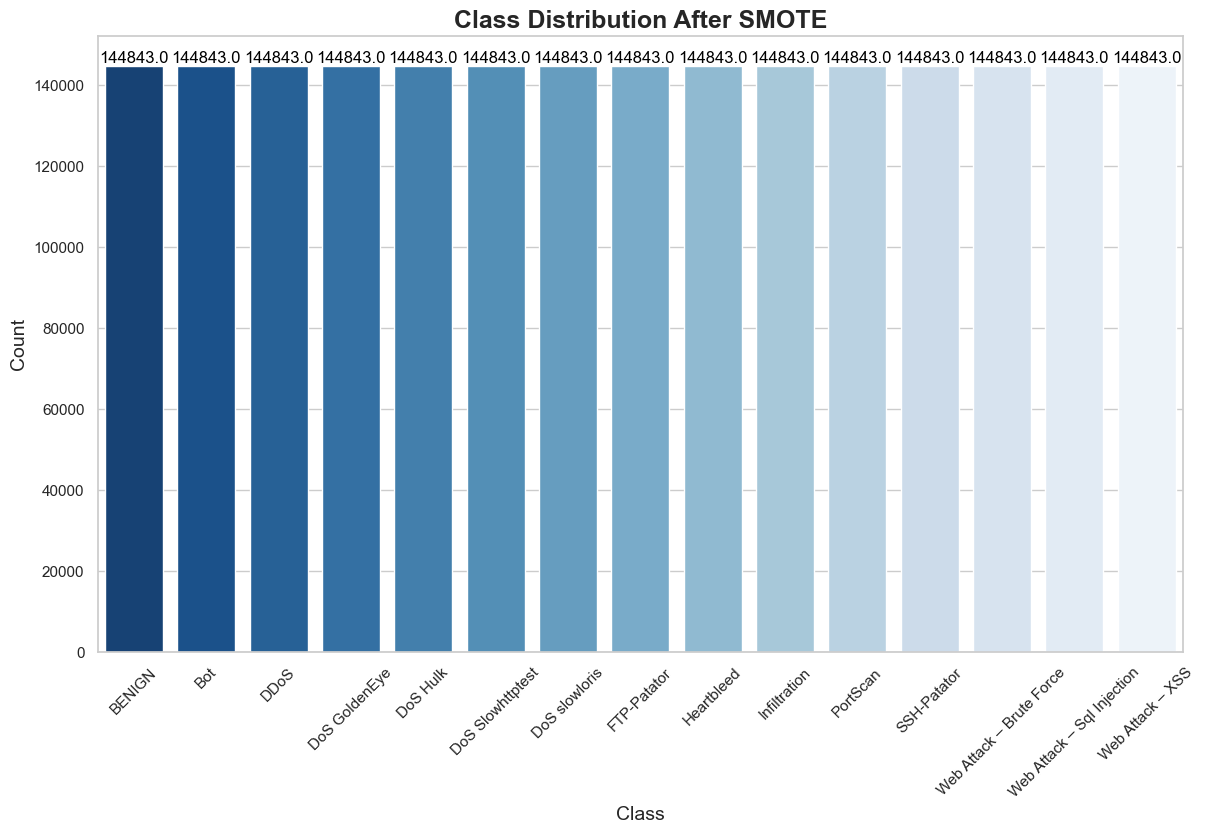

In [20]:
# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Plot class distribution after SMOTE with a muted color palette
plt.figure(figsize=(14, 8))
sns.countplot(x=y_train_smote, hue=y_train_smote, palette="Blues_r", legend=False)  # Simplified color palette

# Add titles and labels
plt.title("Class Distribution After SMOTE", fontsize=18, fontweight='bold')
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Get class labels dynamically from y_train_smote
class_labels = np.unique(y_train_smote)
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45)

# Add count annotations above each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=12, color='black', 
                       xytext=(0, 5), textcoords='offset points')

plt.show()

In [21]:
# Block 4: Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

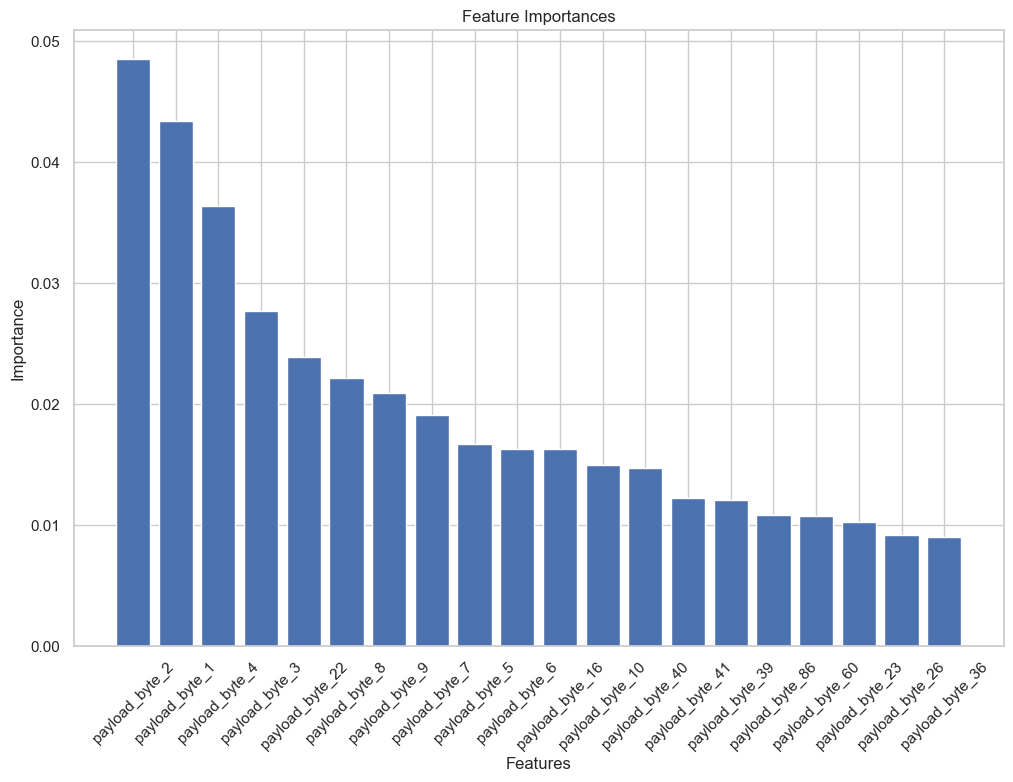

In [22]:
# Feature Importance Plot
plt.figure(figsize=(12, 8))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title("Feature Importances")
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), np.array(X_scaled.columns)[indices[:20]], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [23]:
# Evaluate the model
rf_preds = rf.predict(X_test_pca)

print("\nClassification Report:")
print(classification_report(y_test, rf_preds, zero_division=1))



Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      0.99     72422
                       Bot       1.00      0.66      0.80       509
                      DDoS       1.00      1.00      1.00     48281
             DoS GoldenEye       0.27      0.25      0.26     25625
                  DoS Hulk       0.49      0.39      0.43     50000
          DoS Slowhttptest       0.28      0.37      0.32     16108
             DoS slowloris       0.52      0.68      0.59     24219
               FTP-Patator       1.00      1.00      1.00      6369
                Heartbleed       1.00      1.00      1.00      2697
              Infiltration       1.00      1.00      1.00     23001
                  PortScan       0.42      0.20      0.27       166
               SSH-Patator       0.96      1.00      0.98      9633
  Web Attack – Brute Force       0.99      0.98      0.99      2351
Web Attack – Sql Inject

In [24]:
# Calculate metrics
accuracy = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds, average='weighted', zero_division=1)
recall = recall_score(y_test, rf_preds, average='weighted', zero_division=1)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test_pca), multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


Accuracy: 0.7559
Precision: 0.7581
Recall: 0.7559
ROC-AUC Score: 0.9379


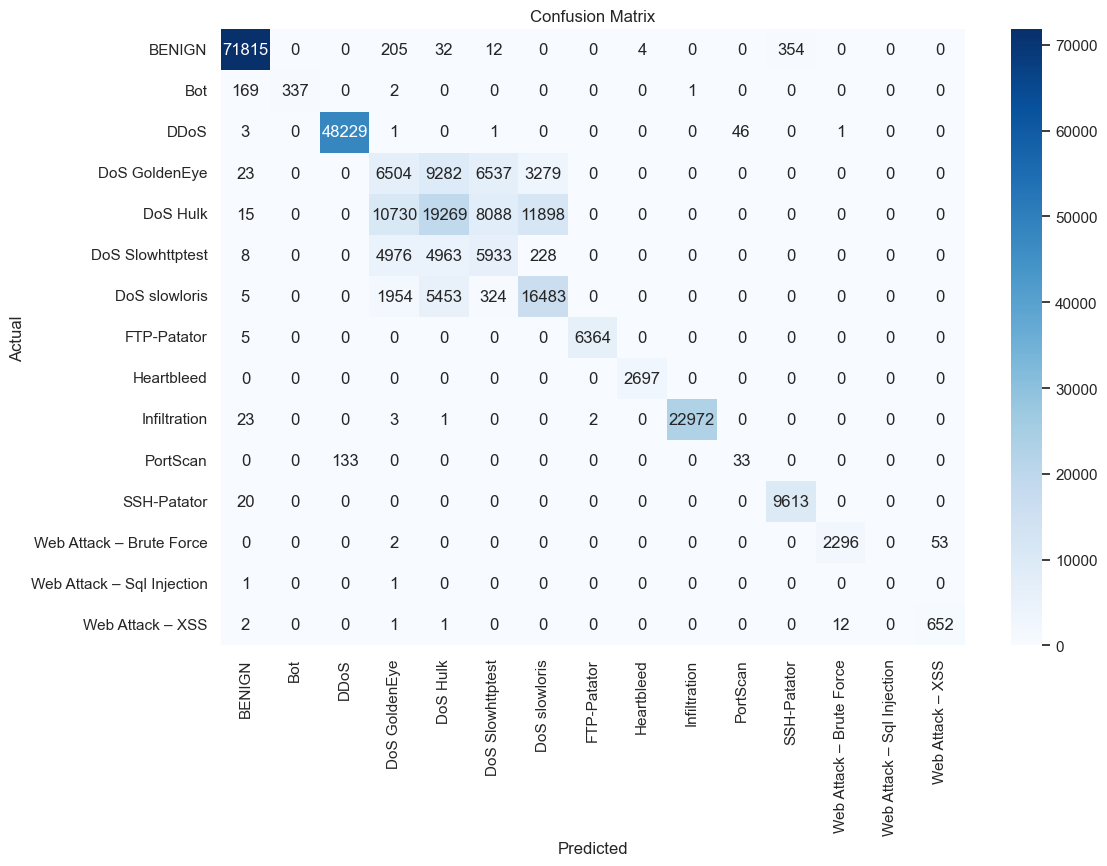

In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Retrieve class names from y_test
class_names = np.unique(y_test)

cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Function to Test Anomaly Detection
def test_anomaly_detection(model, sample_data, true_labels):
    preds = model.predict(sample_data)
    anomalies = preds != true_labels
    anomaly_count = np.sum(anomalies)
    total_samples = len(true_labels)
    print(f"Detected Anomalies: {anomaly_count}/{total_samples}")
    print(f"Anomaly Detection Rate: {anomaly_count / total_samples:.2%}")
    return anomalies


In [27]:
# Example usage of the function
sample_data = X_test_pca[:1000]
true_labels = y_test[:1000]
test_anomaly_detection(rf, sample_data, true_labels)

Detected Anomalies: 258/1000
Anomaly Detection Rate: 25.80%


858128      True
223957     False
1381751    False
1367770    False
1075841    False
           ...  
651503      True
1270985    False
104302     False
1346765    False
898309     False
Name: label, Length: 1000, dtype: bool

In [28]:
#checking class balance
print(data['label'].value_counts())


label
BENIGN                        362108
DoS Hulk                      250000
DDoS                          241405
DoS GoldenEye                 128122
DoS slowloris                 121097
Infiltration                  115007
DoS Slowhttptest               80542
SSH-Patator                    48165
FTP-Patator                    31843
Heartbleed                     13486
Web Attack – Brute Force       11754
Web Attack – XSS                3341
Bot                             2543
PortScan                         830
Web Attack – Sql Injection        12
Name: count, dtype: int64


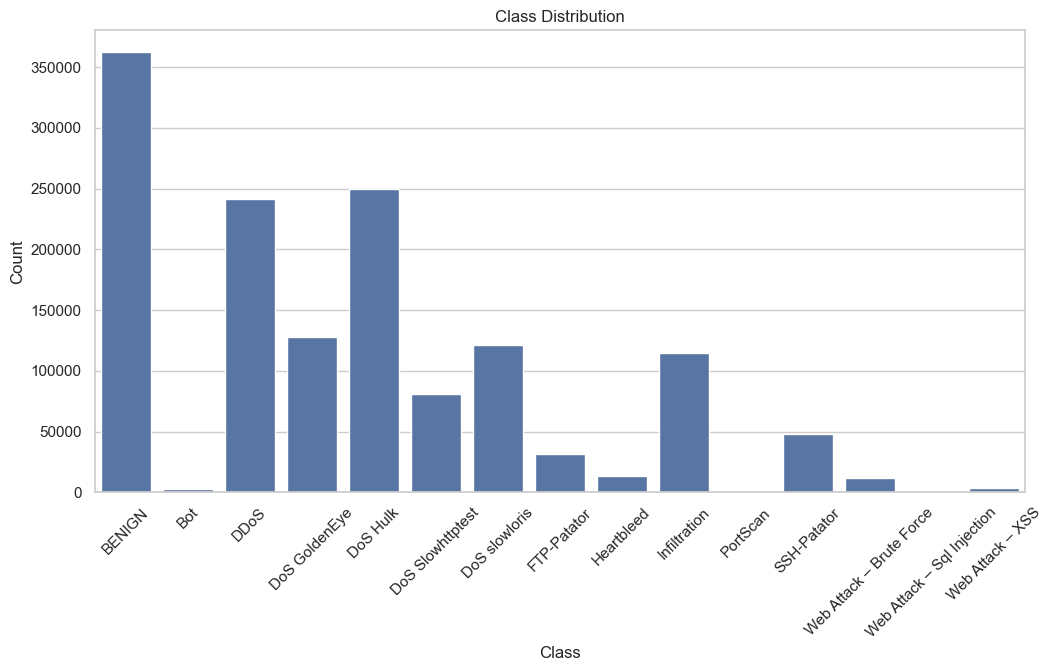

In [29]:
plt.figure(figsize=(12, 6))
sns.countplot(x=data['label'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


**Checking for anomalies**

In [30]:
#percentage of anomalies
normal_count = data[data['label'] == 'BENIGN'].shape[0]
anomaly_count = data[data['label'] != 'BENIGN'].shape[0]
total_count = data.shape[0]

print(f"Normal Samples: {normal_count}")
print(f"Anomaly Samples: {anomaly_count}")
print(f"Anomaly Percentage: {anomaly_count / total_count * 100:.2f}%")


Normal Samples: 362108
Anomaly Samples: 1048147
Anomaly Percentage: 74.32%


In [31]:
#distribution of anomaly types
print(data[data['label'] != 'BENIGN']['label'].value_counts())


label
DoS Hulk                      250000
DDoS                          241405
DoS GoldenEye                 128122
DoS slowloris                 121097
Infiltration                  115007
DoS Slowhttptest               80542
SSH-Patator                    48165
FTP-Patator                    31843
Heartbleed                     13486
Web Attack – Brute Force       11754
Web Attack – XSS                3341
Bot                             2543
PortScan                         830
Web Attack – Sql Injection        12
Name: count, dtype: int64


In [32]:
# Reduce the size of the training set for SVM with stratification
subset_size = 5000  # Define a manageable size for SVM training
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train_smote, y_train_smote, train_size=subset_size, stratify=y_train_smote, random_state=42
)

In [33]:
# Train SVM model
svc = SVC(probability=True, random_state=42)
svc.fit(X_train_subset, y_train_subset)

SVC(probability=True, random_state=42)

In [34]:
# Predictions for SVM
svc_preds = svc.predict(X_test_pca)

In [35]:
# Metrics for SVM
svc_accuracy = accuracy_score(y_test, svc_preds)
svc_precision = precision_score(y_test, svc_preds, average='weighted', zero_division=1)
svc_recall = recall_score(y_test, svc_preds, average='weighted', zero_division=1)
svc_roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test_pca), multi_class='ovr', average='weighted')

In [36]:
print("\nSupport Vector Machine Performance:")
print(f"Accuracy: {svc_accuracy:.4f}")
print(f"Precision: {svc_precision:.4f}")
print(f"Recall: {svc_recall:.4f}")
print(f"ROC-AUC Score: {svc_roc_auc:.4f}")


Support Vector Machine Performance:
Accuracy: 0.6587
Precision: 0.7208
Recall: 0.6587
ROC-AUC Score: 0.9400


In [38]:
# Compare performance with Random Forest
print("\nModel Comparison:")
print(f"{'Metric':<15}{'Random Forest':<15}{'SVM':<15}")
print(f"{'Accuracy':<15}{accuracy:<15.4f}{svc_accuracy:<15.4f}")
print(f"{'Precision':<15}{precision:<15.4f}{svc_precision:<15.4f}")
print(f"{'Recall':<15}{recall:<15.4f}{svc_recall:<15.4f}")
print(f"{'ROC-AUC':<15}{roc_auc:<15.4f}{svc_roc_auc:<15.4f}")



Model Comparison:
Metric         Random Forest  SVM            
Accuracy       0.7559         0.6587         
Precision      0.7581         0.7208         
Recall         0.7559         0.6587         
ROC-AUC        0.9379         0.9400         


In [39]:
# Calculate F1-scores
rf_f1 = precision * recall * 2 / (precision + recall)
svc_f1 = svc_precision * svc_recall * 2 / (svc_precision + svc_recall)

print(f"{'F1-Score':<15}{rf_f1:<15.4f}{svc_f1:<15.4f}")


F1-Score       0.7570         0.6884         


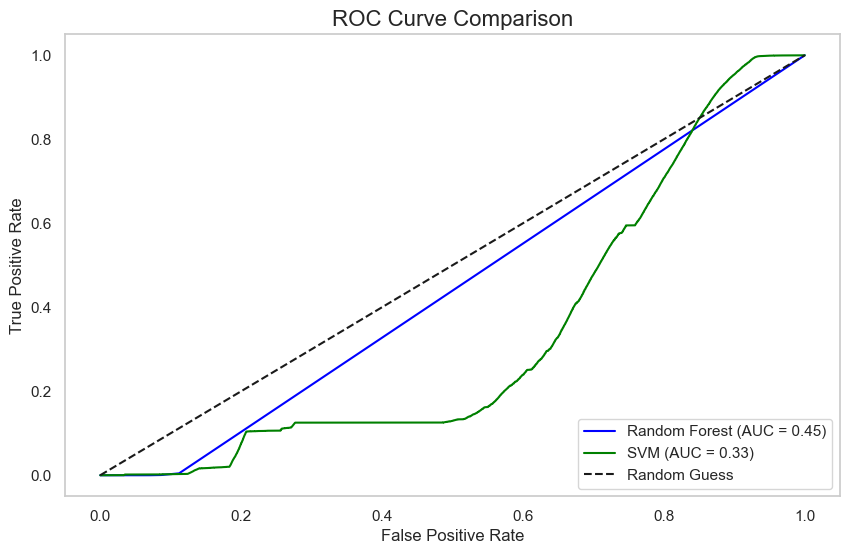

In [40]:
from sklearn.metrics import roc_curve, auc

# Random Forest ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf.predict_proba(X_test_pca)[:, 1], pos_label=y_test.unique()[0])
rf_auc = auc(rf_fpr, rf_tpr)

# SVM ROC curve
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc.predict_proba(X_test_pca)[:, 1], pos_label=y_test.unique()[0])
svc_auc = auc(svc_fpr, svc_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='blue')
plt.plot(svc_fpr, svc_tpr, label=f'SVM (AUC = {svc_auc:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve Comparison', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.grid()
plt.show()


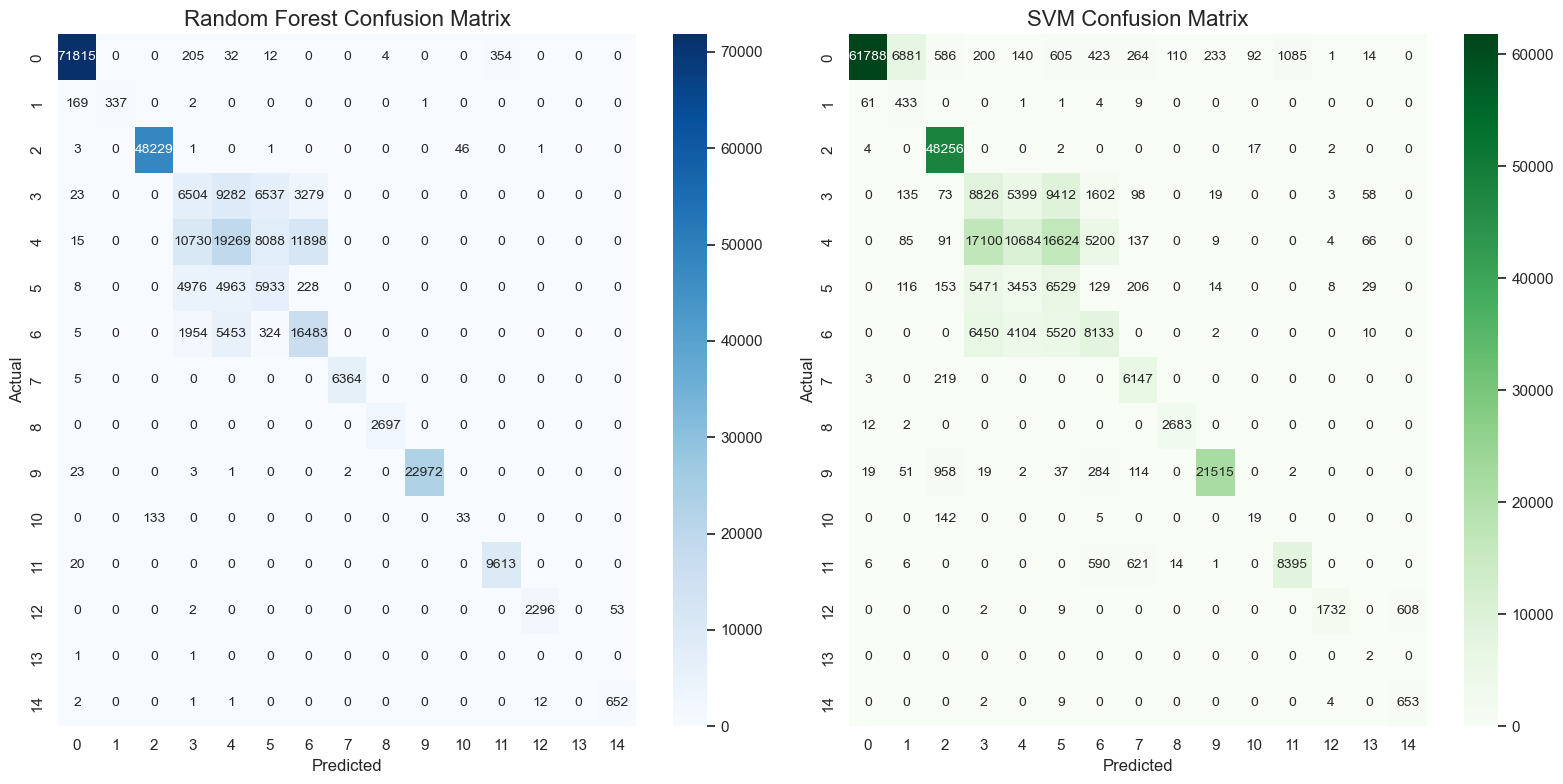

In [45]:
# Plot Confusion Matrices with Enhanced Readability
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest Confusion Matrix
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 10})
axes[0].set_title('Random Forest Confusion Matrix', fontsize=16)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# SVM Confusion Matrix
sns.heatmap(svc_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], annot_kws={"size": 10})
axes[1].set_title('SVM Confusion Matrix', fontsize=16)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

# Adjust layout for clarity
plt.tight_layout()
plt.show()


In [46]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds, zero_division=1))

print("\nSVM Classification Report:")
print(classification_report(y_test, svc_preds, zero_division=1))



Random Forest Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      0.99     72422
                       Bot       1.00      0.66      0.80       509
                      DDoS       1.00      1.00      1.00     48281
             DoS GoldenEye       0.27      0.25      0.26     25625
                  DoS Hulk       0.49      0.39      0.43     50000
          DoS Slowhttptest       0.28      0.37      0.32     16108
             DoS slowloris       0.52      0.68      0.59     24219
               FTP-Patator       1.00      1.00      1.00      6369
                Heartbleed       1.00      1.00      1.00      2697
              Infiltration       1.00      1.00      1.00     23001
                  PortScan       0.42      0.20      0.27       166
               SSH-Patator       0.96      1.00      0.98      9633
  Web Attack – Brute Force       0.99      0.98      0.99      2351
Web Attac